In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#plt.style.use('ggplot')
%precision 4
#np.set_printoptions(suppress=True)

## Interpolation: 

`scipy.interpolate` is useful for fitting a function from experimental data and thus evaluating points where no measure exists. The module is based on the FITPACK Fortran subroutines.

In [ ]:
# the actual measurements
measured_time = np.linspace(0, 1, 10)
noise = (np.random.random(10)*2 - 1) * 1e-1
measures = np.sin(2 * np.pi * measured_time) + noise


In [ ]:
from scipy.interpolate import interp1d
# linear interpolation
linear_interp = interp1d(measured_time, measures)


The kind of interpolation can be specified: linear is the default;  *zero*, *slinear*, *quadratic* and *cubic* refer to a [spline](https://en.wikipedia.org/wiki/Spline) interpolation of zeroth, first, second or third order; *previous* and *next* simply return the previous or next value of the point.

In [ ]:
# cubic interpolation
cubic_interp = interp1d(measured_time, measures, kind='cubic')


In [ ]:
# denser interval to plot the interpolating function
interpolation_time = np.linspace(0, 1, 50)

plt.figure(figsize=(6, 4))
plt.plot(measured_time, measures, 'o', ms=6, label='measures')

linear_results = linear_interp(interpolation_time)
plt.plot(interpolation_time, linear_results, label='linear interp')

cubic_results = cubic_interp(interpolation_time)
plt.plot(interpolation_time, cubic_results, label='cubic interp')
plt.legend()


In [ ]:
# checking the punctual results
x=1/4.
print ("sin(x):",np.sin(2 * np.pi * x), 
       "linear prediction:",linear_interp(x),
       "cubic prediction:", cubic_interp(x))



# Optimization and fit: `scipy.optimize`

Optimization is the problem of finding a numerical solution to a minimization or equality.

The `scipy.optimize` module provides algorithms for function minimization (scalar or multi-dimensional), curve fitting and root finding.

In [ ]:
from scipy import optimize

## Curve Fitting

Fitting is the core business of data analysis or in general data science. If you *know* the underlying model, then the overall problem is simple. If you don't, then it is a very delicate issue.

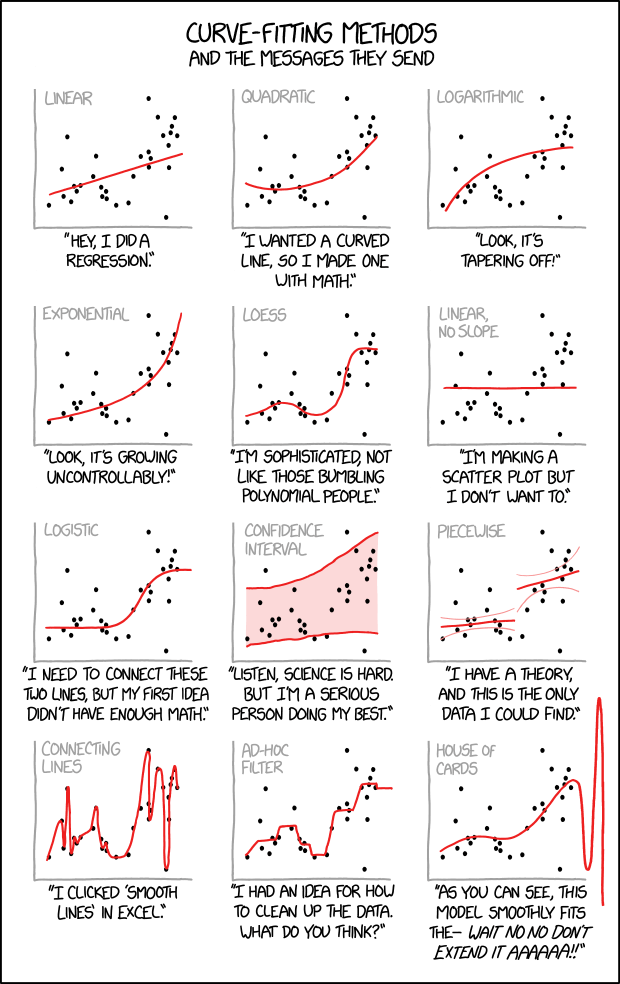

In [44]:
from IPython.display import Image
Image("xkcd_curve_fitting.png")

Let's take some data, sampled from a sine distribution and affected by random noise

In [ ]:
x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data)

If we *known* that the data is sampled from a sine function and we just need to find its parameters, in this case amplitude and frequency, we can do that by least squares curve fitting. 

In [ ]:
def f(x, A, nu):
    return A * np.sin(nu * x)

In [ ]:
# fit by means of curve_fit
# p0 are the guessed values for the parameters
params, params_covariance = optimize.curve_fit(f, x_data, y_data, p0=[2, 2])
print(params)
print (params_covariance)

# get the full output
#optimize.curve_fit(f, x_data, y_data, p0=[2, 2], full_output=True)

As every fitting problem, this transaltes into a minimization problem: the function `f(x_data; params)-y_data` is minimized

In [ ]:
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, f(x_data, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

##  Roots of scalar and functions

Several methods are there for $f(x): {\rm I\!R} \to {\rm I\!R}$, e.g. [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) or Brent (a safer version of the secant method, which combines a bracketing strategy with a parabolic approximation)

In [ ]:
def f(x):
    return x**3-3*x+1

x = np.linspace(-3,3,100)
plt.axhline(0)
plt.plot(x, f(x),'r-');

In [ ]:
from scipy.optimize import brentq
brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3)

In [ ]:
from scipy.optimize import newton
newton(f, -3), newton(f, 0), newton(f, 3)

In case of $f(x): {\rm I\!R}^2 \to {\rm I\!R}$, the `optimize.root` is available, also implementing several methods (MINPACK's hybrd being the default)

In [ ]:
from scipy.optimize import root, fsolve

def f(x):
    return [x[1] - 3*x[0]*(x[0]+1)*(x[0]-1),
            .25*x[0]**2 + x[1]**2 - 1]

solutions = root(f, (0.5, 0.5))
print (solutions)

print (f(solutions.x))

## Minimization of a function

The `minimize_scalar` function will find the minimum, and can also be told to search within given bounds. By default, it uses the Brent algorithm.

In [ ]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

In [ ]:
optimize.minimize_scalar(f, method='Brent')


In [ ]:
optimize.minimize_scalar(f, method='bounded', bounds=[0, 6])


### Local and global minima

In [ ]:
def f(x, offset):
    return -np.sinc(x-offset)

x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [ ]:
# note how additional function arguments are passed in
solution = optimize.minimize_scalar(f, args=(5,))
solution

Optimization results are packed accordingly to  this [format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult)

In [ ]:
plt.plot(x, f(x, 5))
plt.axvline(solution.x,color='b')

When the function oscillates a lot, often the global minimum is not found. To cope with that, several ranges needs to be explored

In [ ]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
solutions = [optimize.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [ ]:
idx = np.argmin([solution.fun for solution in solutions])
solution = solutions[idx]

plt.plot(x, f(x, 5))
plt.axvline(solution.x, color='b');

Alternatively a dedicated method is available

In [ ]:
from scipy.optimize import basinhopping

x0 = 0
solution = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
solution

In [ ]:
plt.plot(x, f(x, 5))
plt.axvline(solution.x, color='b');

Minimization of f(x): ${\rm I\!R}^n \to {\rm I\!R}$ is a whole field of study per se. You should have seen it treated in details in other courses.

# Statistics and random numbers: `scipy.stats`

The module scipy.stats contains statistical tools and probabilistic descriptions of random processes. Random number generators for various random process can be found in numpy.random.

Given observations of a random process, their histogram is an estimator of the random process’s PDF (probability density function):

In [ ]:
# Sample from a normal distribution using numpy's random number generator
samples = np.random.normal(size=10000)

# Compute a histogram of the sample
bins = np.linspace(-5, 5, 60)

# Compute the PDF on the bin centers from scipy distribution object
from scipy import stats
bin_centers = 0.5*(bins[1:] + bins[:-1])
pdf = stats.norm.pdf(bin_centers)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
_,_,_ = plt.hist(samples, bins, label="Histogram of samples", density=True)
plt.plot(bin_centers, pdf, label="PDF")
plt.legend()

If we know that the random process belongs to a given family of random processes, such as normal processes, we can do a maximum-likelihood fit of the observations to estimate the parameters of the underlying distribution. Here we fit a normal process to the observed data:


In [ ]:
mean, std = stats.norm.fit(samples)
print (mean, std)  

## Statistical tests

A statistical test is a decision indicator. For instance, if we have two sets of observations, that we assume are generated from Gaussian processes, we can use a [T-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to decide whether the means of two sets of observations are significantly different:

In [ ]:
# Generates 2 sets of observations
samples1 = np.random.normal(0, size=100)
samples2 = np.random.normal(0.1, size=100)

# Compute a histogram of the sample
bins = np.linspace(-4, 4, 30)
histogram1, bins = np.histogram(samples1, bins=bins, density=True)
histogram2, bins = np.histogram(samples2, bins=bins, density=True)

plt.figure(figsize=(6, 4))
plt.hist(samples1, bins=bins, density=True, label="Samples 1")
plt.hist(samples2, bins=bins, density=True, label="Samples 2")
plt.legend(loc='best')

In [ ]:
stats.ttest_ind(samples1, samples2)

In [ ]:
# most of the test statistics are available 
stats.chisquare(samples1,samples2)

## Numerical integration: `scipy.integrate`

### Function integrals

The most generic integration routine is `scipy.integrate.quad()`, which integrate from a to b (possibly infinite interval) using a technique from the Fortran library QUADPACK.

 Let's compute $\int_0^{\pi/2} \sin{\theta}d\theta$:


In [ ]:
from scipy.integrate import quad, quadrature
res, err = quad(np.sin, 0, np.pi/2)

# An alternative is the gaussian quadrature
#res, err = quadrature(np.sin, 0, np.pi/2)

print (res, err)
print (np.allclose(res, 1))   # res is the result, is should be close to 1

print (np.allclose(err, 1 - res))  # err is an estimate of the err

`scipy.integrate.nquad()` generalize to multiple integration variables

In [ ]:
from scipy.integrate import nquad
func = lambda x0,x1,x2,x3 : x0**2 + x1*x2 - x3**3 + np.sin(x0) + (
                                1 if (x0-.2*x3-.5-.25*x1>0) else 0)
points = [[lambda x1,x2,x3 : 0.2*x3 + 0.5 + 0.25*x1], [], [], []]
def opts0(*args, **kwargs):
    return {'points':[0.2*args[2] + 0.5 + 0.25*args[0]]} 

result, abserr, out = nquad(func, [[0,1], [-1,1], [.13,.8], [-.15,1]], opts=[opts0,{},{},{}], full_output=True)

print (result, abserr)
print (out)

### Integrating differential equations

`scipy.integrate` also features routines for integrating Ordinary Differential Equations (ODE). In particular, `scipy.integrate.odeint()` solves ODE of the form:

```python
dy/dt = rhs(y1, y2, .., t0,...)
```

As an introduction, let us solve the ODE $\frac{dy}{dt} = -2 y$ between $t = 0 \dots 4$, with the initial condition $y(t=0) = 1$. First the function computing the derivative of the position needs to be defined:


In [ ]:
def calc_derivative(ypos, time):
    return -2 * ypos

Then, to compute y as a function of time:

In [ ]:
from scipy.integrate import odeint
time_vec = np.linspace(0, 4, 40)
y = odeint(calc_derivative, y0=1, t=time_vec)


plt.figure(figsize=(4, 3))
plt.plot(time_vec, y)
plt.xlabel('t: Time')
plt.ylabel('y: Position')
plt.tight_layout()

Let us integrate a more complex ODE: a damped spring-mass oscillator. The position of a mass attached to a spring obeys the 2nd order ODE $y'' + 2 \varepsilon \omega_0  y' + \omega_0^2 y = 0$ with $\omega_0^2 = k/m$ with $k$ the spring constant, $m$ the mass and $\varepsilon = c/(2 m \omega_0)$ with $c$ the damping coefficient. We set:

In [ ]:
mass = 0.5  # kg
kspring = 4  # N/m
cviscous = 0.4  # N s/m

# and thus
eps = cviscous / (2 * mass * np.sqrt(kspring/mass))
omega = np.sqrt(kspring / mass)

For `odeint()`, the 2nd order equation needs to be transformed in a system of two first-order equations for the vector $Y = (y, y')$: the function computes the velocity and acceleration:

In [ ]:
def calc_derivative(yvec, time, eps, omega):
    return (yvec[1], -eps * omega * yvec[1] - omega **2 * yvec[0])

In [ ]:
time_vec = np.linspace(0, 10, 100)
yinit = (1, 0)
yarr = odeint(calc_derivative, yinit, time_vec, args=(eps, omega))

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(time_vec, yarr[:, 0], label='y')
plt.plot(time_vec, yarr[:, 1], label="y'")
plt.legend(loc='best')

## Fast Fourier Trasform

The `scipy.fftpack` module computes fast Fourier transforms (FFTs) and offers utilities to handle them. The main functions are:

* `scipy.fftpack.fft()` to compute the FFT
* `scipy.fftpack.fftfreq()` to generate the sampling frequencies
* `scipy.fftpack.ifft()` computes the inverse FFT, from frequency space to signal space

Let's generate a noisy signal:

In [ ]:
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt

# Seed the random number generator
np.random.seed(1234)

time_step = 0.02
period = 5.

time_vec = np.arange(0, 20, time_step)
sig = (np.sin(2 * np.pi / period * time_vec)
       + 0.5 * np.random.randn(time_vec.size))

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')


Let's compute and plot the power spectrum

In [ ]:
# The FFT of the signal
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
print (np.allclose(peak_freq, 1./period))

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection

In [ ]:
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')
